In [3]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import xarray as xr
import matplotlib.colors as pltc
import geopandas
import datetime as dt
from scipy import stats
# from sklearn import preprocessing
import s3fs
import matplotlib as mpl
import sys, os, glob,re
mpl.rcParams['pdf.fonttype'] = 42

## Cubic feet to cubic meters conversion factor
cfs_2_cms = 0.0283168466

In [4]:
pnwNP = pd.read_csv("../data/pnwNP_Info.csv")

In [43]:
path  = "../data/NWIS_streamflow/"
    gage = '*'+str(shp['gage'][i])+'*'
    file = glob.glob("../data/NWIS_streamflow/"+gage)[0]

In [126]:
i=2
fields = ['X_00060_00003', 'Date']

## Get NWM 2.0 data
# slice all data using a specific reach identifier and time range
timerange = slice('1979-01-31', '2011-12-31')
dat = ds.sel(feature_id=pnwNP['comid'][i],
             time=timerange).streamflow.persist() 

# This step takes a bit longer because it's actually returning the data
dat = dat.resample(time='1d').mean()

NWM = pd.DataFrame(dat.to_pandas())
NWM['time'] = pd.to_datetime(NWM.index)
NWM.columns = ["streamflow_NWM2d0","time"]
NWM = NWM.reset_index(drop=True)
NWM["gage"] = shp['gage'][i]


# ## Get NWIS Data
path  = "../data/NWIS_streamflow/"
gage = '*'+str(shp['gage'][i])+'*'
file = glob.glob("../data/NWIS_streamflow/"+gage)[0]

NWIS = pd.read_csv(file,usecols=fields)
NWIS.columns = ["time","streamflow_NWIS"]
NWIS['time'] = pd.to_datetime(NWIS['time']).dt.tz_localize(None)
NWIS["streamflow_NWIS"] = NWIS["streamflow_NWIS"]*cfs_2_cms

## Combine all the data
datMain = pd.merge(NWM,NWIS, on='time',how='inner')

datMain.to_csv('../data/pnwNP_modeledData/'+str(shp['gage'][i])+".csv")
    

In [130]:
datMain

,streamflow_NWM2d0,time,streamflow_NWIS
0,0.100000,1993-01-01,0.113267
1,0.100000,1993-01-02,0.127426
2,0.100000,1993-01-03,0.127426
3,0.100000,1993-01-04,0.127426
4,0.100000,1993-01-05,0.127426
...,...,...,...
6934,0.090000,2011-12-27,2.384278
6935,0.095417,2011-12-28,2.355962
6936,0.111250,2011-12-29,2.364457
6937,0.110833,2011-12-30,2.381447


BOULDER CREEK NEAR CEDAR FALLS, WA


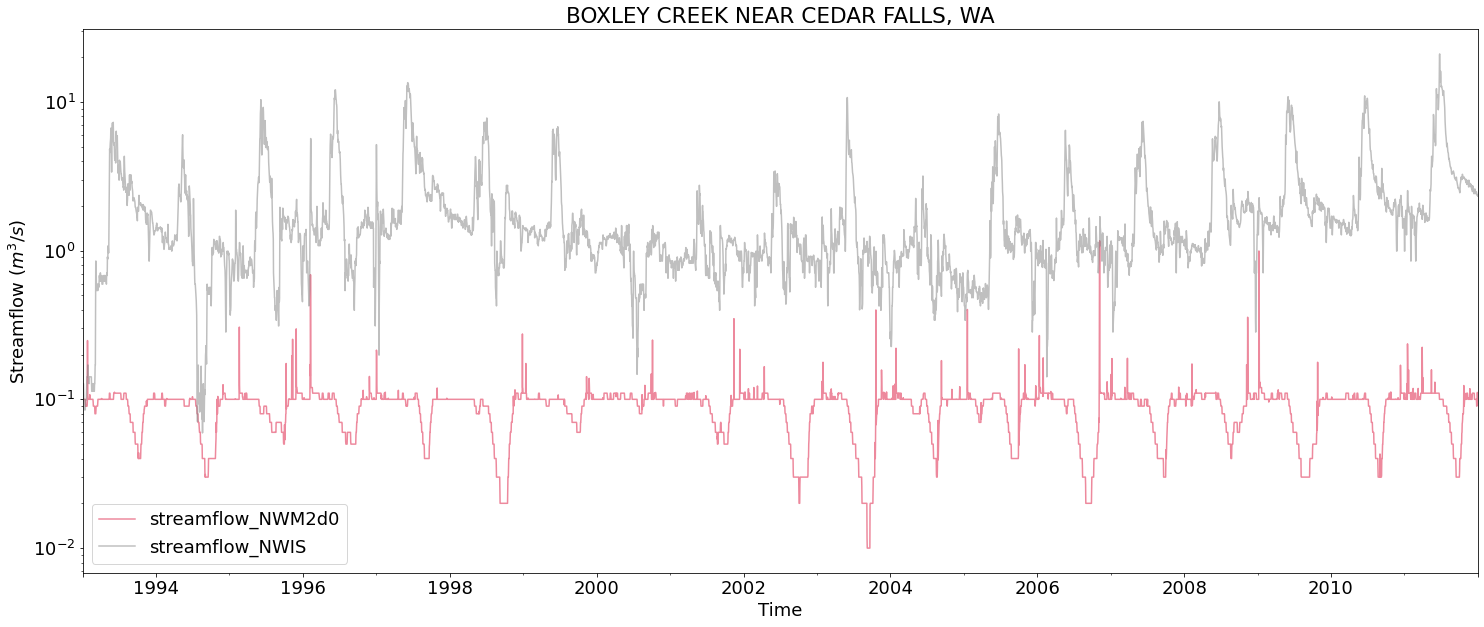

In [150]:
i=2
plt.rcParams.update({'font.size': 18})
name = print(str(pnwNP['station_nm_x'][0]))
# datMain =  datMain.drop('gage',axis=1)
# ax = datMain.plot(x = "time",figsize = (25,10),logy=True,alpha=0.5,color = ['purple','green','crimson','grey'])
ax = datMain.plot(x = "time",figsize = (25,10),logy=True,alpha=0.5,color = ['crimson','grey'])
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow $(m^3/s)$')
ax.set_title(pnwNP['station_nm_x'][i])
# plt.savefig("../docs/SFTeton_streamflow.pdf")
plt.savefig('../docs/pnwModeled/'+str(shp['gage'][i])+"_streamflow.pdf")

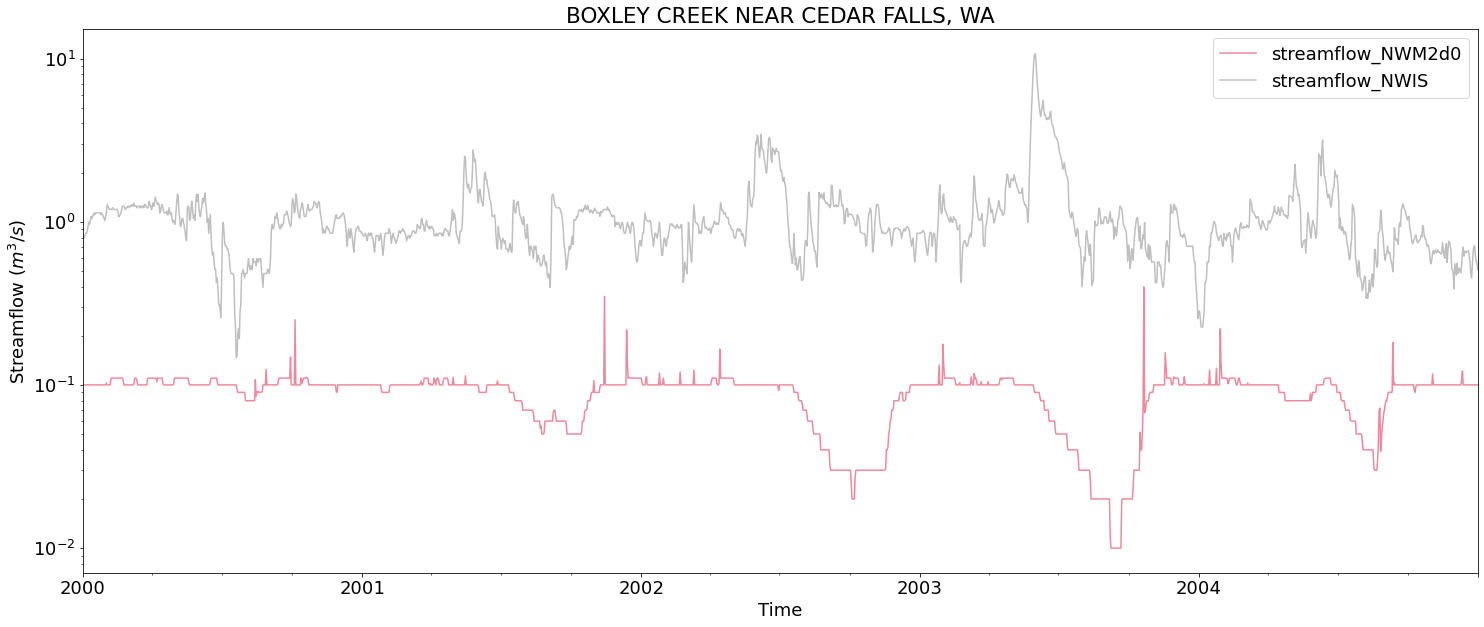

In [154]:
sub = datMain[ (datMain["time"] >= '2000-01-01') & (datMain["time"] <= '2004-12-31')]
# ax = sub.plot(x = "time",figsize = (25,10),logy=True,alpha=0.5,color = ['purple','green','crimson','grey'])
ax = sub.plot(x = "time",figsize = (25,10),logy=True,alpha=0.5,color = ['crimson','grey'])
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow $(m^3/s)$')
ax.set_title(pnwNP['station_nm_x'][i])
# plt.savefig("../docs/SFTeton_streamflowSubset.pdf")
plt.savefig('../docs/pnwModeled/'+str(shp['gage'][i])+"_streamflowSubset.pdf")

In [147]:
## Make a normalized dataframe for plotting
tt = datMain
tt.index = datMain['time']
tt =  tt.drop('time',axis=1)
tt = pd.DataFrame(preprocessing.minmax_scale(tt))
tt.index = datMain['time']
# tt.columns = ["streamflow_VIC","streamflow_PRMS","streamflow_NWM2d0","streamflow_NWIS"]
tt.columns = ["streamflow_NWM2d0","streamflow_NWIS"]


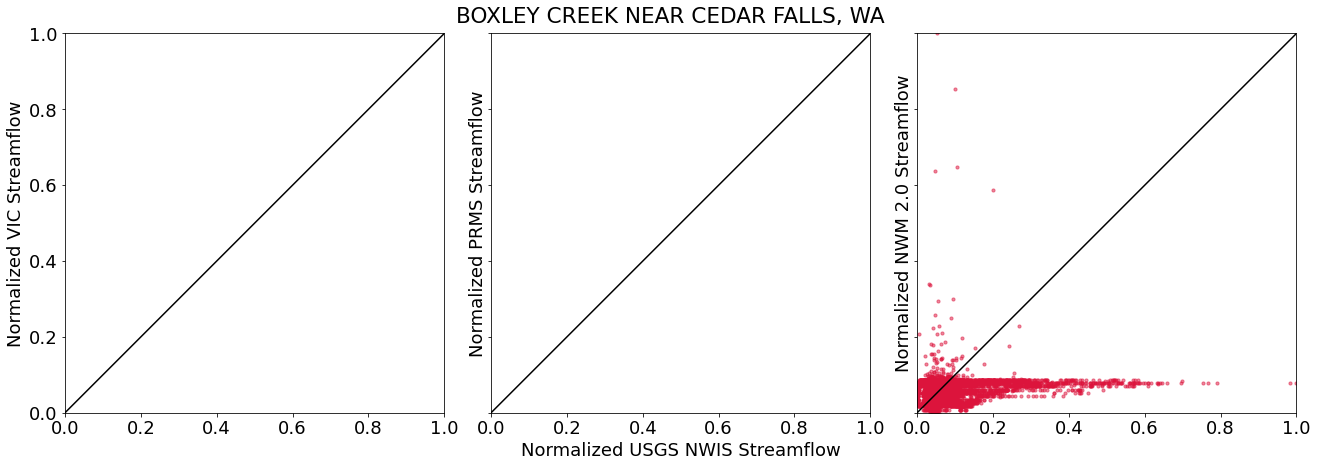

In [155]:
fig, axs = plt.subplots(1,3, sharey=True,figsize=(18,6),subplot_kw=dict(box_aspect=1))
fig.suptitle(pnwNP['station_nm_x'][i])


pt = (0, 0)
plt.tight_layout(pad=0.4, w_pad=1, h_pad=0.5)
# axs[0].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_VIC"],alpha = 0.5,color = "purple",s=10)
# axs[1].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_PRMS"],alpha = 0.5,color = 'green',s=10)
axs[2].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_NWM2d0"],alpha = 0.5,color = 'crimson',s=10)
axs[0].axline(pt,slope=1, color='black')
axs[1].axline(pt,slope=1, color='black')
axs[2].axline(pt,slope=1, color='black')
axs[0].set_ylabel('Normalized VIC Streamflow')
axs[1].set_ylabel('Normalized PRMS Streamflow')
axs[2].set_ylabel('Normalized NWM 2.0 Streamflow')
axs[1].set_xlabel('Normalized USGS NWIS Streamflow')
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,1)
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_ylim(0,1)
axs[2].set_xlim(0,1)

plt.savefig('../docs/pnwModeled/'+str(shp['gage'][i])+"_1to1.pdf",bbox_inches='tight')